In [1]:
from sowce.data.dataset_classes import VisiumCohort
from loguru import logger
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

/home/owkin/.local/conda/envs/sowce_env_2/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/owkin/.local/conda/envs/sowce_env_2/lib/python3.9/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/owkin/.config/sagemaker/config.yaml


In [84]:
id_sample = "CH_B_006b_vis"

In [96]:
fpath = f"/home/owkin/project/CSIDE_RESULTS/covariates_cside/regions_using_beta_4components_intersect_both_margin/{id_sample}.csv"
df = pd.read_csv(fpath)

dataset_id = "dataset-dc3510e2-76eb-47f6-9bb4-d20d340ee808"
zarr_dir = f"/home/owkin/data/{dataset_id}/without_spotclean/SpatialData"
path_dataset = f"{zarr_dir}/*.zarr"
dataset = VisiumCohort(
    path_dataset=path_dataset,
    normalization="log_norm_count", # load log(1+CPM) data
    deconvolution_slot_name = "deconv_cohort_level_2",
    radius=1,
    ignore_sample_ids=["CH_B_015a_vis_Visium"], # We need to ignore this samples that failed QC to avoid an error in dataset.filter_umi() later
    list_sample_ids=[id_sample]
)
_ = dataset.load_counts_cohort()
_ = dataset.load_deconvolution_cohort() # include cell type mapping in this function if needed

sample = dataset._dict_visium_samples[id_sample]
df_coords = sample.coords
fpath_coords = f"/home/owkin/project/cytocommunity_results/fractions/raw/{id_sample}_Coordinates.txt"

# Replace 'your_file_name.txt' with the actual path to your text file.

x_values = []
y_values = []

try:
    with open(fpath_coords, 'r', encoding='utf-8') as file:
        for line in file:
            # Split the line into parts and store x and y values
            parts = line.strip().split()  # Adjust the delimiter if needed (e.g., ',' or '\t')
            if len(parts) == 2:  # Ensure there are two values in each line
                x, y = map(float, parts)  # Convert to float, or int if appropriate
                x_values.append(x)
                y_values.append(y)

except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Filter the dataframe
filtered_df = df_coords.loc[df_coords.index.get_level_values("x").isin(x_values) & df_coords.index.get_level_values("y").isin(y_values)]
merged_df = pd.merge(df, df_coords, on="barcode", how="inner")

In [97]:
merged_df

,barcode,annotation,imagerow,imagecol,array_col,array_row,norm_x,norm_y
0,AACAGGATTCATAGTT-1,CC Stroma,679.064049,598.145973,43,49,60.387000,53.191213
1,AACAGGTTCACCGAAG-1,CC Stroma,698.441946,607.751155,41,51,62.110214,54.045372
2,AACAGTCCACGCGGTG-1,CC Stroma,343.776175,796.950908,10,12,30.570919,70.870302
3,AACATCTAATGACCGG-1,CC TI Edge,843.524874,523.259058,55,67,75.011976,46.531759
4,AACATCTTAAGGCTCA-1,CC Stroma,381.861840,805.383365,8,16,33.957755,71.620173
...,...,...,...,...,...,...,...,...
2111,TGTTGCGTCCAAGATT-1,CC Stroma,690.512086,478.695479,65,51,61.405037,42.568862
2112,TGTTGGAACCTTCCGC-1,CC Stroma,550.734347,649.243309,35,35,48.975049,57.735136
2113,TGTTGGAACGAGGTCA-1,CC TI Edge,472.943539,454.291615,72,28,42.057360,40.398704
2114,TGTTGGATGGACTTCT-1,CC TI Edge,338.861896,565.086276,53,13,30.133907,50.251320


In [88]:
x = filtered_df.index.get_level_values("x")
y = filtered_df.index.get_level_values("y")

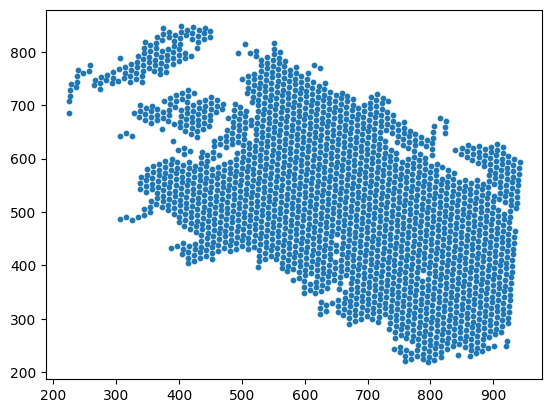

In [95]:
plt.scatter(x,y, s=10)

In [3]:
def plot_results(method, data, gmm, ax):
    """Plot the results of the deconvolution.

    Parameters
    ----------
    method : str
        The method used to fit the distribution. Can be "beta" or "gaussian".
    data : np.ndarray
        The data to plot.
    gmm : sklearn.mixture.GaussianMixture or sklearn.mixture.BayesianGaussianMixture
        The fitted distribution.
    ax : matplotlib.axes.Axes
        The axes to plot on.
    """
    x = np.linspace(0, 1, 1000)
    if method == "beta":
        alphas, betas, weights = gmm.alphas_, gmm.betas_, gmm.weights_
        estimated_pdfs = [
            pi * beta.pdf(x, alpha_p, beta_p)
            for alpha_p, beta_p, pi in zip(alphas, betas, weights)
        ]
    if method == "gaussian":
        means, covariances_, weights = (
            gmm.means_,
            gmm.covariances_,
            gmm.weights_,
        )
        estimated_pdfs = [
            pi * norm.pdf(x, mean, np.sqrt(cov))
            for mean, cov, pi in zip(means, covariances_, weights)
        ]
        estimated_pdfs = [x[0] for x in estimated_pdfs]
    estimated_mixture_pdf = np.sum(estimated_pdfs, axis=0)

    ax.hist(
        data,
        bins=1000,
        density=True,
        alpha=0.5,
        color="gray",
        label="Observed data",
    )
    if method == "beta":
        for k, (pdf, alpha_p, beta_p, pi) in enumerate(
            zip(estimated_pdfs, alphas, betas, weights)
        ):
            ax.plot(
                x,
                pdf,
                "--",
                label=rf"Estimated Beta{k+1} PDF (alpha={alpha_p:.2f}, beta={beta_p:.2f}, pi={pi:.2f})",
            )
    if method == "gaussian":
        for k, (pdf, mean, cov, pi) in enumerate(
            zip(estimated_pdfs, means, covariances_, weights)
        ):
            ax.plot(
                x,
                pdf,
                "--",
                label=f"Estimated Gaussian{k+1} PDF (mean={mean.item():.2f}, cov={cov.item():.2f}, pi={pi.item():.2f})",
            )
    ax.plot(x, estimated_mixture_pdf, "g-", label="Estimated Mixture PDF")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.legend(loc="upper right", fontsize="xx-small")

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


[0.17863295483291058, 0.9999999999999999]


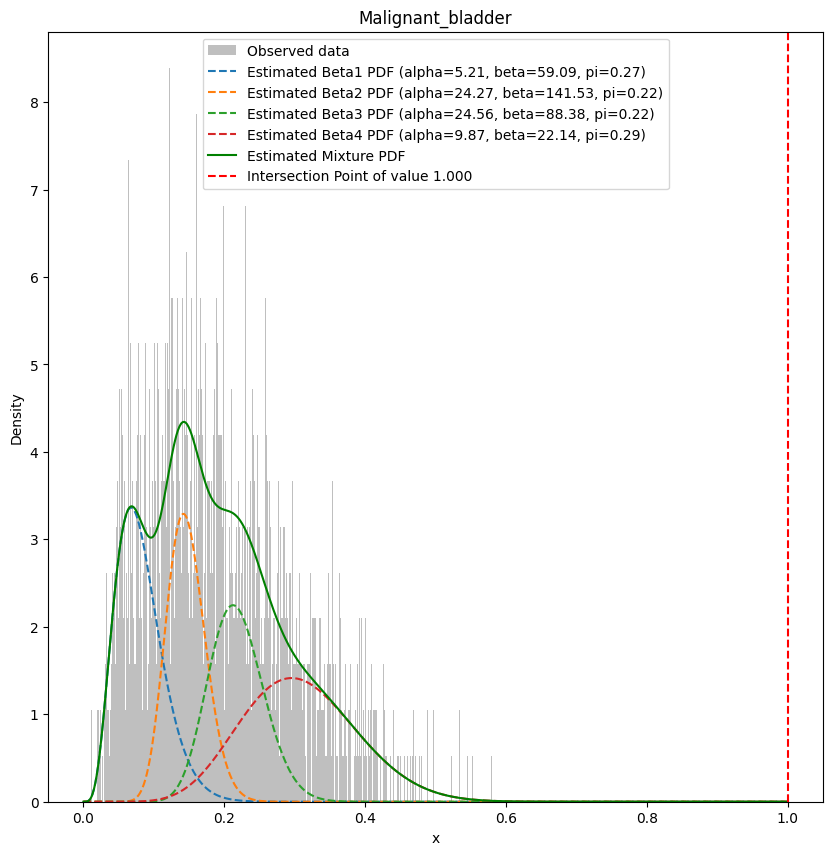

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, norm

from sowce.data.dataset_classes import VisiumCohort
from sowce.utils.analysis_utils import concat_deconv
from sowce.analysis.cell_colocalisation import find_optimal_distribution, find_intersection_points_between_two_dist

#dataset_id = "dataset-c1521eca-c504-4752-8597-bd375b4deaa1"
dataset_id = "dataset-dc3510e2-76eb-47f6-9bb4-d20d340ee808"

zarr_dir = f"/home/owkin/data/{dataset_id}/without_spotclean/SpatialData"

path_dataset = f"{zarr_dir}/*.zarr"
visium_cohort = VisiumCohort(
    path_dataset=path_dataset,
    normalization="raw_count",
    deconvolution_slot_name = "deconv_cohort_level_2",
    radius=None,
    list_sample_ids=["CH_B_001b_vbu"]
)

deconvolution_dict = visium_cohort.load_deconvolution_cohort()

deconv_res = concat_deconv(visium_cohort)

celltypes = ["Malignant_bladder"]
components_list = [4]
distribution = "beta"
tol = 1e-3
max_iter = 500

component_dict, dist_dict = find_optimal_distribution(
    deconv_res=deconv_res,
    features=celltypes,
    components_list=components_list,
    distribution=distribution,
    tol=tol,
    max_iter=max_iter,
)

gmm = dist_dict["Malignant_bladder"]
intersection_points = find_intersection_points_between_two_dist(gmm, mode1=1, mode2=2, distribution=distribution)
print(intersection_points)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for celltype, gmm in dist_dict.items():
    values = deconv_res[celltype].values
    plot_results(distribution, values, gmm, ax=ax)
    ax.set_title(f"{celltype}")
    ax.axvline(
        [intersection_points[1]],
        color="r",
        linestyle="--",
        label=f"Intersection Point of value {intersection_points[1]:.3f}",
    )
plt.legend()
plt.show()

# Regions vs TCNs

In [15]:
fpath = "/home/owkin/project/cytocommunity_results/stroma_edge_islet/stroma_edge_islet_CH_B_002b_vbu.csv"
df = pd.read_csv(fpath)

In [16]:
df

,barcode,y,x,Malignant_bladder,Smoothed_tumor,region
0,AACACTTGGCAAGGAA-1,71,47,1,1,CC TI Edge
1,AACAGGATTCATAGTT-1,43,49,1,1,CC Tumor Islet
2,AACAGGTTATTGCACC-1,86,28,0,0,CC Stroma
3,AACAGGTTCACCGAAG-1,41,51,1,1,CC Tumor Islet
4,AACAGTCGTGTCGCGG-1,124,44,1,1,CC TI Edge
...,...,...,...,...,...,...
3088,TGTTGCGTCCAAGATT-1,65,51,1,1,CC Tumor Islet
3089,TGTTGGAACCTTCCGC-1,35,35,1,1,CC Tumor Islet
3090,TGTTGGAACGAGGTCA-1,72,28,1,1,CC Tumor Islet
3091,TGTTGGCCAGACCTAC-1,47,49,1,1,CC Tumor Islet


In [29]:
ids = [
    "CH_B_001b_vbu", "CH_B_002b_vbu", "CH_B_003b_vbu", "CH_B_004b_vbu",
    "CH_B_006b_vis", "CH_B_008b_vis", "CH_B_009b_vis", "CH_B_010a_vis",
    "CH_B_011a_vis", "CH_B_013a_vis", "CH_B_016a_vis", "CH_B_019a_vis",
    "CH_B_020a_vis", "CH_B_022a_vis", "CH_B_023a_vis", "CH_B_025a_vis",
    "CH_B_027a_vis", "CH_B_029a_vis", "CH_B_030a_vis", "CH_B_031a_vis",
    "CH_B_032a_vis", "CH_B_033a_vbu", "CH_B_034a_vis", "CH_B_035a_vis",
    "CH_B_036a_vis", "CH_B_037a_vis", "CH_B_039a_vis", "CH_B_041a_vbu",
    "CH_B_044a_vbu", "CH_B_045a_vis", "CH_B_046a_vis", "CH_B_047a_vbu",
    "CH_B_050a_vis", "CH_B_052a_vis", "CH_B_053a_vbu", "CH_B_054a_vbu",
    "CH_B_055a_vis", "CH_B_056a_vis", "CH_B_057a_vis", "CH_B_058a_vis",
    "CH_B_059a_vis", "CH_B_060a_vis", "CH_B_062a_vis", "CH_B_063a_vis",
    "CH_B_064a_vis", "CH_B_066a_vis", "CH_B_067a_vis", "CH_B_068a_vis",
    "CH_B_069a_vis", "CH_B_070a_vis", "CH_B_071a_vis", "CH_B_072a_vis",
    "CH_B_073a_vis", "CH_B_074a_vis", "CH_B_075a_vis", "CH_B_076a_vis",
    "CH_B_077a_vis", "CH_B_078a_vis", "CH_B_079a_vis", "CH_B_080a_vis",
    "CH_B_082a_vis", "CH_B_083a_vis", "CH_B_084a_vis", "CH_B_085a_vis",
    "CH_B_086a_vis", "CH_B_087a_vis", "CH_B_088a_vis", "CH_B_090a_vis",
    "CH_B_092a_vis", "CH_B_093a_vis", "CH_B_094a_vis", "CH_B_095a_vis",
    "CH_B_096a_vis", "CH_B_097a_vis"
]

before = []
after = []
for sample_id in ids:
    fpath = f"/home/owkin/project/cytocommunity_results/stroma_edge_islet/stroma_edge_islet_{sample_id}.csv"
    df = pd.read_csv(fpath)
    after.append(df.shape[0])
    
    fpath = f"/home/owkin/project/cytocommunity_results/fractions/raw/{sample_id}_Coordinates.txt"
    with open(fpath, 'r') as file:
        line_count = sum(1 for line in file)
    before.append(line_count)

before = np.array(before)
after = np.array(after)

Text(0, 0.5, 'Number of samples')

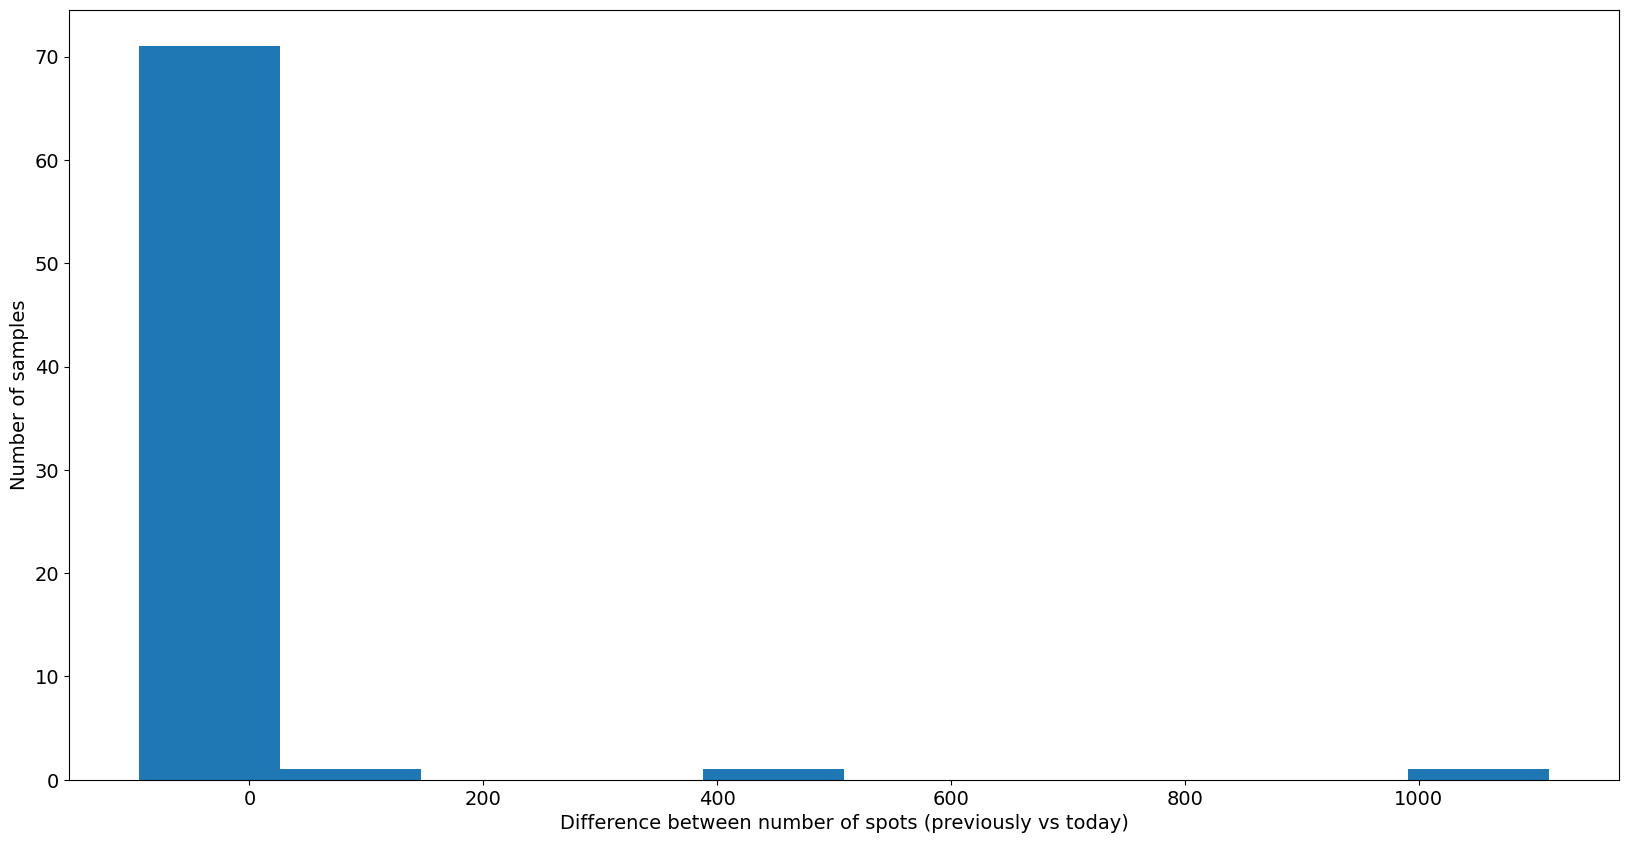

In [49]:
plt.figure(figsize=(20,10))
plt.hist(before-after)
plt.xlabel("Difference between number of spots (previously vs today)")
plt.ylabel("Number of samples")

([<matplotlib.axis.XTick at 0x7f3820cd6940>,
 [Text(0, 0, 'CH_B_001b_vbu'),
  Text(1, 0, 'CH_B_002b_vbu'),
  Text(2, 0, 'CH_B_003b_vbu'),
  Text(3, 0, 'CH_B_004b_vbu'),
  Text(4, 0, 'CH_B_006b_vis'),
  Text(5, 0, 'CH_B_008b_vis'),
  Text(6, 0, 'CH_B_009b_vis'),
  Text(7, 0, 'CH_B_010a_vis'),
  Text(8, 0, 'CH_B_011a_vis'),
  Text(9, 0, 'CH_B_013a_vis'),
  Text(10, 0, 'CH_B_016a_vis'),
  Text(11, 0, 'CH_B_019a_vis'),
  Text(12, 0, 'CH_B_020a_vis'),
  Text(13, 0, 'CH_B_022a_vis'),
  Text(14, 0, 'CH_B_023a_vis'),
  Text(15, 0, 'CH_B_025a_vis'),
  Text(16, 0, 'CH_B_027a_vis'),
  Text(17, 0, 'CH_B_029a_vis'),
  Text(18, 0, 'CH_B_030a_vis'),
  Text(19, 0, 'CH_B_031a_vis'),
  Text(20, 0, 'CH_B_032a_vis'),
  Text(21, 0, 'CH_B_033a_vbu'),
  Text(22, 0, 'CH_B_034a_vis'),
  Text(23, 0, 'CH_B_035a_vis'),
  Text(24, 0, 'CH_B_036a_vis'),
  Text(25, 0, 'CH_B_037a_vis'),
  Text(26, 0, 'CH_B_039a_vis'),
  Text(27, 0, 'CH_B_041a_vbu'),
  Text(28, 0, 'CH_B_044a_vbu'),
  Text(29, 0, 'CH_B_045a_vis'),
  Tex

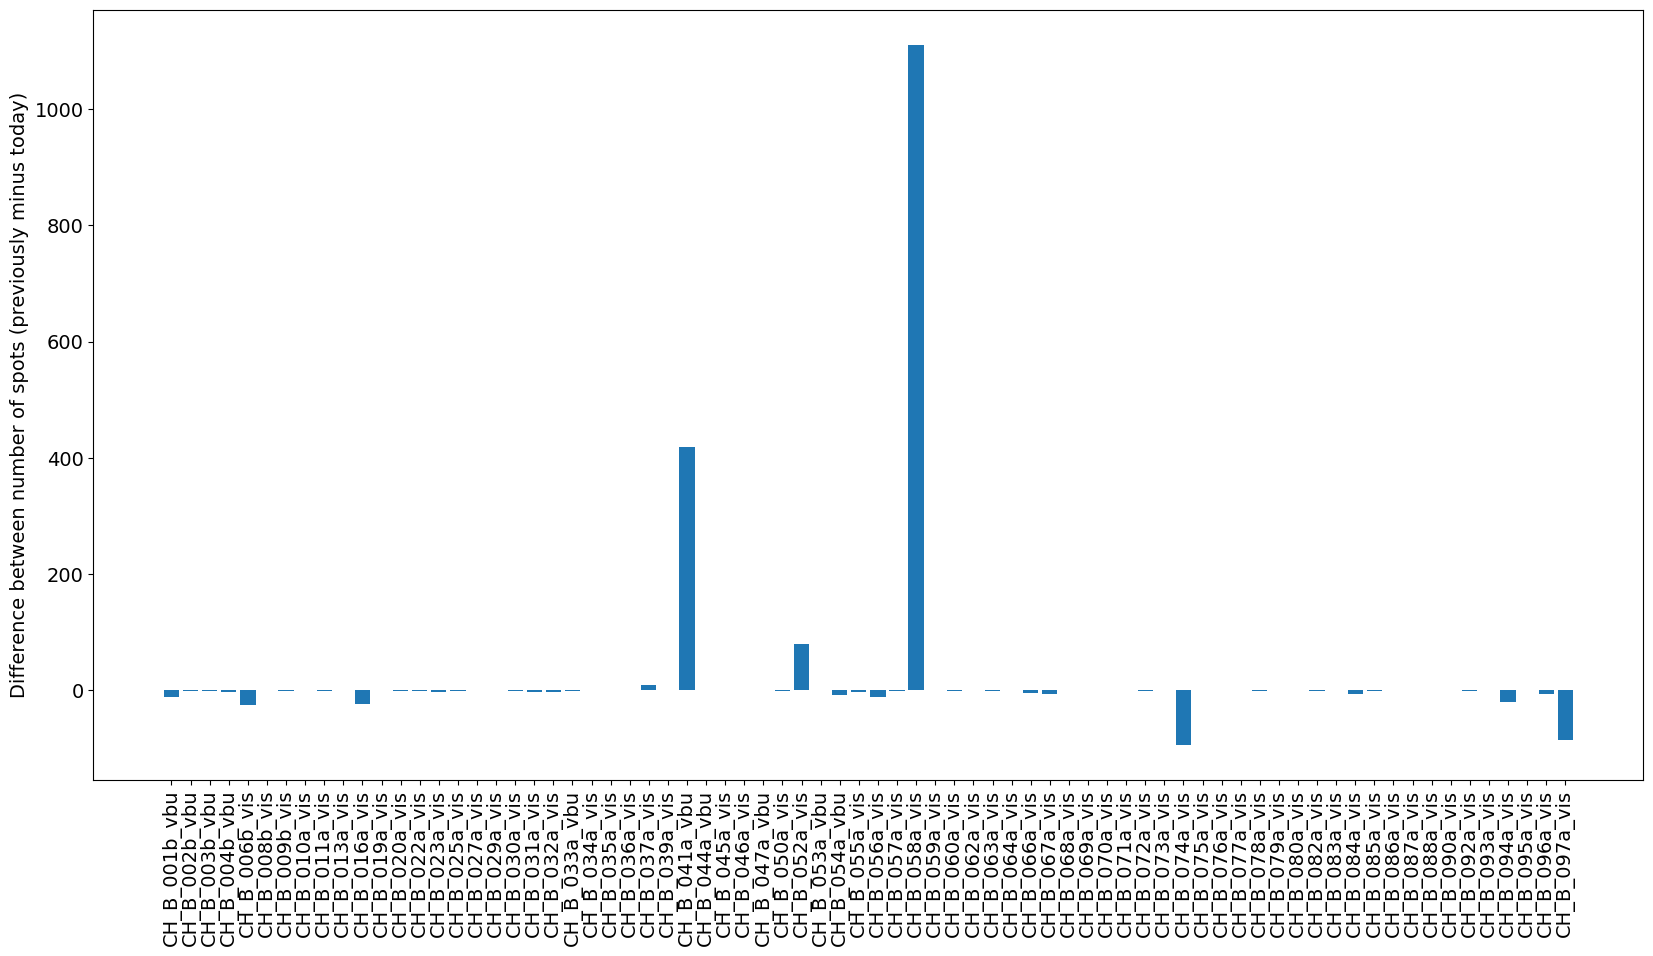

In [51]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,10))
plt.bar(x=range(74), height=before-after)
plt.ylabel("Difference between number of spots (previously minus today)")
plt.xticks(ticks=range(74), labels=ids, rotation=90)

In [25]:
after

[2661]